# Import DataFrame and Prep Model

### Imports

In [0]:
#Arrays and Dataframe
import numpy as np
import pandas as pd

#SQL
from sqlalchemy import create_engine

#Visualization
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import pylab

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format # can choose the number of decimal points to see

#Data Outliers
from sklearn.preprocessing import QuantileTransformer

#Data Normilization and Scaling
from sklearn.preprocessing import normalize, scale, StandardScaler, MinMaxScaler

#Data Exploration
from wordcloud import WordCloud #may have to do pip install wordcloud from terminal
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy import stats
from scipy.stats import zscore
import math
from scipy.stats.mstats import winsorize

#Feature Selection
from sklearn.decomposition import PCA

#Data Modeling
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from sklearn import neighbors

#Model Metrics
from sklearn.utils.multiclass import unique_labels
import itertools
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import r2_score
from sklearn import metrics


#Testing model assumptions
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf

#Overfitting Linear Models
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

### Query and DataFrame Creation

In [0]:
#Make SQL Queary
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [417]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

### Handle Missing Values

In [0]:
#Drop columns that have a large number of null values (over 30%) or are meaningless
df1 = df.drop(columns = ['alley', 'fireplacequ', 'poolqc', 'fence', 'miscfeature', 'id', 'lotshape', 'landcontour', 'lotconfig', 'condition1', 'condition2', 'roofstyle', 'roofmatl', 'heating', 'heatingqc', 'garagequal', 'paveddrive'])

In [0]:
#make a copy of df1
df2 = df1.copy()

#interpolate based on the year
year_list = list(df1['yearbuilt'].unique())
for year in year_list:
    df2.loc[df1['yearbuilt']==year] = df2.loc[df1['yearbuilt']==year].interpolate()

# drop missing values that are remaining
df2.dropna(inplace = True)

### Remove Unneccesary Features

In [0]:
# df3 = df2.drop(columns = ['mssubclass', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'lowqualfinsf', 'halfbath', 'totrmsabvgrd', 'garageyrblt', 'garagearea', 'openporchsf', 'enclosedporch', 'poolarea', 'miscval', 'mszoning', 'neighborhood', 'bldgtype', 'exterior1st', 'exterior2nd', 'exterqual', 'bsmtcond', 'bsmtfintype2', 'electrical', 'functional', 'garagefinish', 'saletype', 'mszoning', 'neighborhood', 'bldgtype', 'exterior1st', 'exterior2nd', 'exterqual', 'bsmtcond', 'bsmtfintype1', 'electrical', 'functional', 'garagetype', 'extercond', 'bedroomabvgr', 'threessnporch', 'utilities', 'mosold', 'landslope', 'housestyle', 'extercond', 'bsmtexposure', 'garagecond', 'salecondition'])

### Update Datatypes

In [0]:
#update data types
non_numeric = df2.select_dtypes(include = 'object')
numeric = df2.select_dtypes(include = ['float64', 'int64'])

In [0]:
#all of the columns that were in numeric that are actually non-numeric
numeric_dropped = numeric.loc[:, ['overallqual', 'overallcond', 'yrsold', 'mssubclass', 'yearbuilt', 'yearremodadd', 'garageyrblt', 'mosold']]
#combining all non-numeric columns
non_numeric1 = pd.concat([non_numeric, numeric_dropped], axis = 1)

In [0]:
#dropping the non-numeric columns from numeric
numeric1 = numeric.drop(columns = ['overallqual', 'overallcond', 'yrsold', 'mssubclass', 'yearbuilt', 'yearremodadd', 'garageyrblt', 'mosold'])

### Analyize Numeric Features

In [424]:
#check correlation
correlation = numeric1[numeric1.columns[:]].corr()['saleprice'][:]

#get absolute value and sort
corr_abs = correlation.abs().sort_values(ascending=False)

#keeping features for now, can remove later
list_features = corr_abs[0:30].index.tolist()
list_features

['saleprice',
 'grlivarea',
 'garagecars',
 'garagearea',
 'firstflrsf',
 'totalbsmtsf',
 'fullbath',
 'totrmsabvgrd',
 'masvnrarea',
 'fireplaces',
 'bsmtfinsf1',
 'openporchsf',
 'lotfrontage',
 'wooddecksf',
 'secondflrsf',
 'halfbath',
 'lotarea',
 'bsmtfullbath',
 'bsmtunfsf',
 'bedroomabvgr',
 'enclosedporch',
 'kitchenabvgr',
 'screenporch',
 'poolarea',
 'threessnporch',
 'bsmthalfbath',
 'bsmtfinsf2',
 'miscval',
 'lowqualfinsf']

### Analyze Non_Numeric Features

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


ValueError: ignored

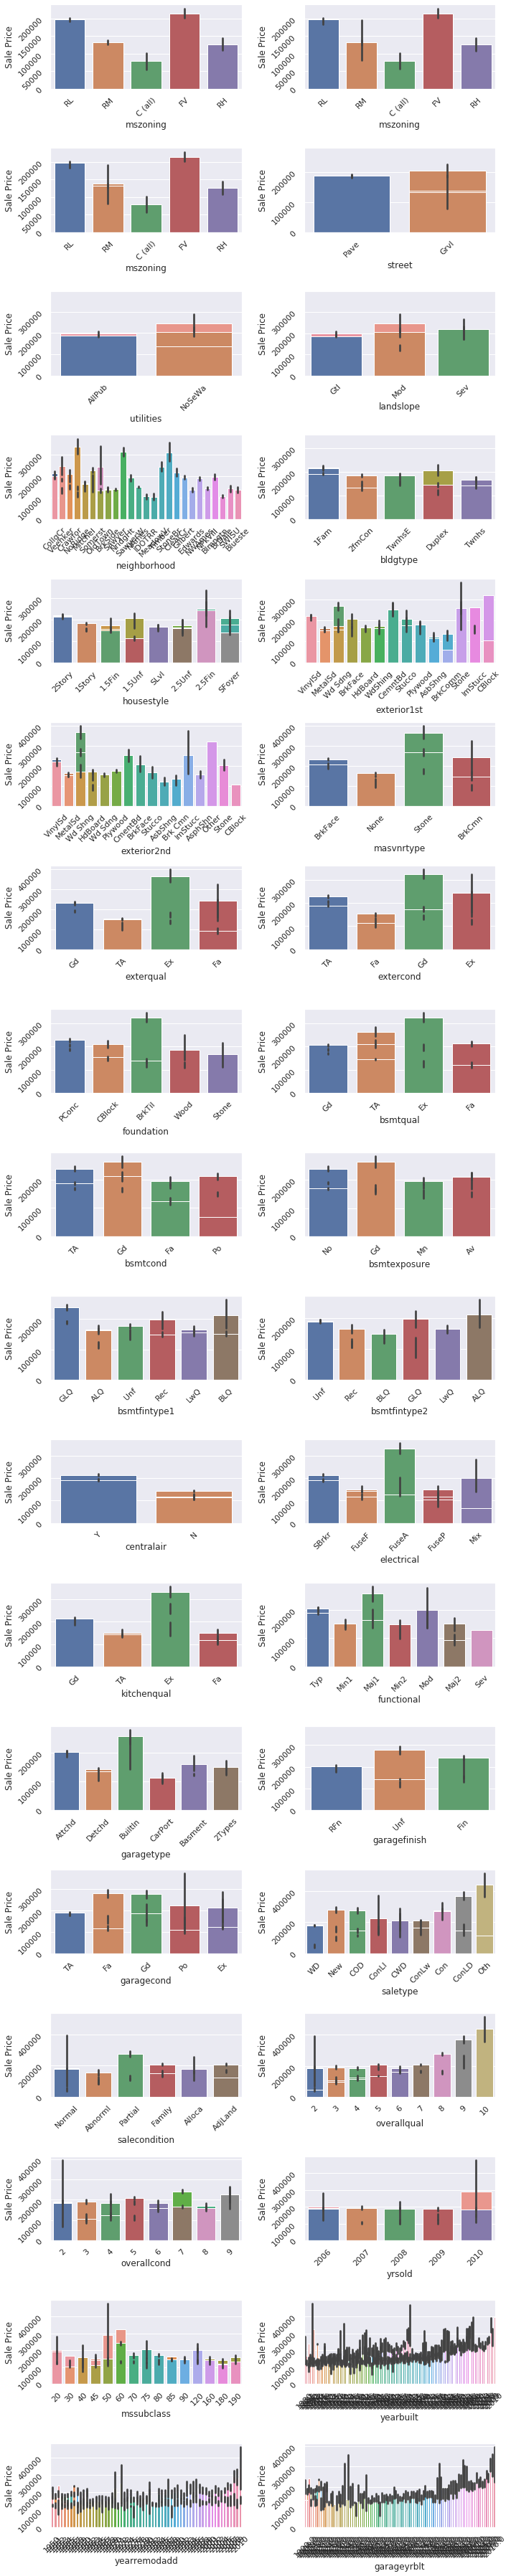

In [425]:
plt.figure(figsize = (10, 50))

for i in range(1, 36, 1):
    for features1 in non_numeric1:
        plt.subplot(18,2,i)
        sns.barplot(non_numeric1[features1], numeric1['saleprice'])
        plt.xticks(rotation = 45)
        plt.yticks(rotation = 45)
        plt.xlabel(features1)
        plt.ylabel('Sale Price')
        plt.tight_layout()
        i+=1

plt.show()

In [0]:
#drop features that are visibly not correlated to salesprice (there is not much variance
#within the feature and saleprice)
non_numeric2 = non_numeric1.drop(columns = ['street', 'utilities', 'landslope', 'bldgtype', 'bsmtexposure', 'bsmtcond','bsmtfintype1', 'bsmtfintype2', 'salecondition', 'overallcond'])

In [0]:
#Also drop features that are logically correlated with each other 
non_numeric2.drop(columns = ['kitchenqual', 'extercond', 'exterior2nd'], inplace = True)

### Check for Correlation Between Non-Numerical Features

In [0]:
##If multicolinearity exists between the categorical features, this can be remedied through Lasso Regression. 

### Check for Normality with Saleprice

(array([ 91., 661., 353., 133.,  52.,  17.,   4.,   3.,   2.,   2.]),
 array([ 35311. , 107279.9, 179248.8, 251217.7, 323186.6, 395155.5,
        467124.4, 539093.3, 611062.2, 683031.1, 755000. ]),
 <a list of 10 Patch objects>)

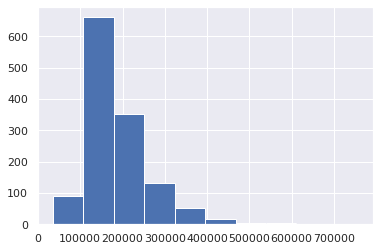

In [453]:
plt.hist(numeric1['saleprice'])

### One Hot Encoding / Ordinal Encoding

In [0]:
#Separate between what will be ordinal and one hot encoded
ordinal = non_numeric2.loc[:, ['exterqual', 'bsmtqual', 'garagecond', 'overallqual']]

to_hot_encode = non_numeric2.drop(ordinal.columns, axis = 1)


In [0]:
#Map ordinal categorical variables
ordinal1 = ordinal.copy()
mapping = {'Ex': 5, 'Gd': 4, 'Fa': 3, 'TA': 2, 'Po': 1}

ordinal1['exterqual'] = ordinal1['exterqual'].map(mapping)
ordinal1['bsmtqual'] = ordinal1['bsmtqual'].map(mapping)
ordinal1['garagecond'] = ordinal1['garagecond'].map(mapping) 

In [0]:
#one hot endoding to non_numeric
non_numeric2 = pd.get_dummies(to_hot_encode, drop_first = True)

In [0]:
#join back dataframes
df4 = pd.concat([numeric1, non_numeric2, ordinal1], axis = 1)

# Model 1

### Split Train Test Data

In [475]:
#Separate target variable from rest of data
X = df4.drop(columns = ['saleprice'])
y = df4['saleprice']
X = sm.add_constant(X)

#split train_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .2)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Build Model

In [476]:
#build OLS model and fit to training data

model = sm.OLS(y_train, X_train)
ols_results = model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     48.99
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        20:44:52   Log-Likelihood:                -12385.
No. Observations:                1054   AIC:                         2.500e+04
Df Residuals:                     938   BIC:                         2.558e+04
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3.363e+05 

### Evaluation Metrics

In [478]:
y_preds_train = ols_results.predict(X_train)
y_preds_test = ols_results.predict(X_test)

ms_error = mean_squared_error(y_test, y_preds_test)
print(ms_error)

876896031.2221696


In [777]:
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Mean absolute error of the prediction is: 15327.140647739063
Mean squared error of the prediction is: 516629897.55915713
Root mean squared error of the prediction is: 22729.494001388528
Mean absolute percentage error of the prediction is: 8.38251512775899


# Model 2

### Drop features based on VIF and Colinearity

In [0]:
df5 = df4.copy()
df5.drop(columns = ['garagetype_Detchd', 'garagetype_BuiltIn', 'garagetype_Attchd', 'masvnrtype_None', 'exterior1st_VinylSd', 'exterior1st_MetalSd', 'neighborhood_OldTown', 'neighborhood_Gilbert', 'yearbuilt'], inplace = True)

In [0]:
df5.drop(columns = ['saletype_ConLw', 'garagefinish_Unf', 'functional_Maj2', 'electrical_FuseP', 'electrical_FuseF', 'exterior1st_ImStucc', 'exterior1st_CBlock', 'housestyle_2.5Unf', 'neighborhood_SawyerW', 'neighborhood_Sawyer', 'neighborhood_NAmes', 'neighborhood_MeadowV', 'neighborhood_Blueste', 'yrsold', 'enclosedporch', 'openporchsf', 'garagearea', 'lowqualfinsf', 'bsmtfinsf2','housestyle_1Story', 'firstflrsf', 'threessnporch', 'garageyrblt'], inplace = True)

### Variable Transformations

In [0]:
df5['lotarea'] = np.log(df5['lotarea'])
df5['lotfrontage'] = np.log(df5['lotfrontage'])
df5['totalbsmtsf'] = np.log(df5['totalbsmtsf'])
df5['grlivarea'] = np.log(df5['grlivarea'])


### Check for Correlation Amongst Features

In [728]:
correlations = df5[df5.columns[:]].corr()['masvnrtype_BrkFace'][:]
corr_abs = correlations.abs().sort_values(ascending=False)
corr_abs

masvnrtype_BrkFace   1.000
masvnrarea           0.557
masvnrtype_Stone     0.225
overallqual          0.193
garagecars           0.191
                      ... 
functional_Mod       0.010
saletype_ConLI       0.009
poolarea             0.005
saletype_ConLD       0.002
kitchenabvgr         0.001
Name: masvnrtype_BrkFace, Length: 88, dtype: float64

In [0]:
corr = df5.corr()

### Check for Normality

(array([208., 716., 336.,  45.,   7.,   4.,   0.,   0.,   0.,   2.]),
 array([ 21. ,  50.2,  79.4, 108.6, 137.8, 167. , 196.2, 225.4, 254.6,
        283.8, 313. ]),
 <a list of 10 Patch objects>)

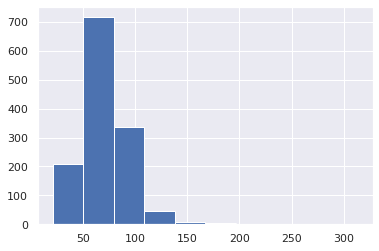

In [730]:
plt.hist((df4['lotfrontage']))

(array([ 42.,  37.,  64., 324., 536., 248.,  54.,  11.,   0.,   2.]),
 array([3.04452244, 3.31469051, 3.58485859, 3.85502666, 4.12519474,
        4.39536281, 4.66553089, 4.93569896, 5.20586704, 5.47603512,
        5.74620319]),
 <a list of 10 Patch objects>)

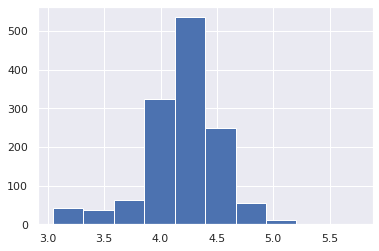

In [731]:
plt.hist(np.log(df4['lotfrontage']))

### Split Train Test Data

In [783]:
#Separate target variable from rest of data
X = df5.drop(columns = ['saleprice'])
y = np.log(df5['saleprice'])
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Fit Model

In [784]:
#build OLS model and fit to training data

model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     107.2
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:46:43   Log-Likelihood:                 753.18
No. Observations:                1054   AIC:                            -1332.
Df Residuals:                     967   BIC:                            -900.8
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.0899 

### Evaluation Metrics

In [751]:
y_preds_test = np.exp(results.predict(X_test))

ms_error = mean_squared_error(np.exp(y_test), y_preds_test)
print(ms_error)

516629897.55915666


In [778]:
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Mean absolute error of the prediction is: 15327.140647739063
Mean squared error of the prediction is: 516629897.55915713
Root mean squared error of the prediction is: 22729.494001388528
Mean absolute percentage error of the prediction is: 8.38251512775899


After transformations, dropping unneccessary features, the best MSE is 516,629,897 USD. This is down from 876,896,031 USD in the first model.

# Model 3: Ridge, Lasso, and Elastic Net Models

In [788]:
#Separate target variable from rest of data
X = df5.drop(columns = ['saleprice'])
y = np.log(df5['saleprice'])
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [804]:
#Ridge Regression (L2)

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=.0001) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.9050366444305543
-----Test set statistics-----
R-squared of the model on the test set is: 0.9097557316830207
Mean absolute error of the prediction is: 0.08309582458531715
Mean squared error of the prediction is: 0.011433296055676062
Root mean squared error of the prediction is: 0.1069265919015287
Mean absolute percentage error of the prediction is: 0.6910370220524583


In [799]:
#Lasso (L1)
lassoregr = Lasso(alpha=.4) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.6626100167174986
-----Test set statistics-----
R-squared of the model on the test set is: 0.7125034709679943
Mean absolute error of the prediction is: 0.14105266971156105
Mean squared error of the prediction is: 0.036423730755471596
Root mean squared error of the prediction is: 0.19085002162816644
Mean absolute percentage error of the prediction is: 1.1744603371212687


In [800]:
#ElasticNet (L1 and L2)

elasticregr = ElasticNet(alpha=1, l1_ratio=0.1) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.6789238164586251
-----Test set statistics-----
R-squared of the model on the test set is: 0.7294677992414134
Mean absolute error of the prediction is: 0.13744088749599853
Mean squared error of the prediction is: 0.034274473066834725
Root mean squared error of the prediction is: 0.18513366270571843
Mean absolute percentage error of the prediction is: 1.1447278479755538


### Test Model Assumptions for Model #2

#### Assumption one: linearity of the model in its coefficients should be a linear relationship in the visual

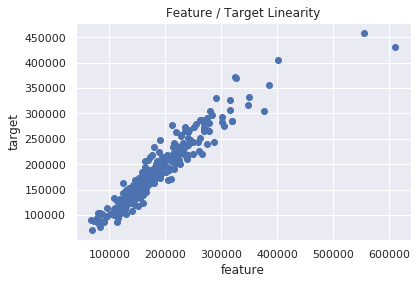

In [680]:
#should look linear 
y_test = np.exp(y_test)
plt.scatter(y_test, y_preds_test)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Feature / Target Linearity')
plt.show()

#### Assumption two: the error term should be zero on average

In [681]:

errors = y_test - y_preds_test

print("Mean of the errors in the house costs model is: {}".format(np.mean(errors)))

Mean of the errors in the house costs model is: 66.47010512998294


#### Assumption three: homoscedasticity. Should be centered around zero. 

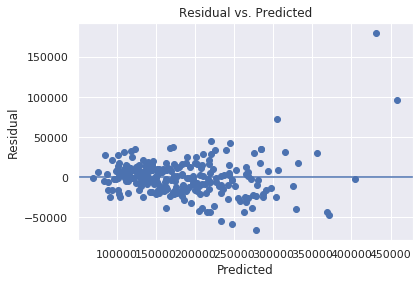

Bartlett test statistic value is 259.436 and p value is 2.28e-58
Levene test statistic value is 167.088 and p value is 2.19e-33


In [683]:
#should be centered around zero
plt.scatter(y_preds_test, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

#Bartlett and Levene tests: should be above .05
bart_stats = bartlett(y_preds_test, errors)
lev_stats = levene(y_preds_test, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

#### Assumption four: low multicollinearity. Each should be below 5. 

In [684]:
#VIF Method
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range (X.shape[1])], index=X.columns)

with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
     print(vif)


const                  27474.085
lotfrontage                2.171
lotarea                    2.858
masvnrarea                 2.377
bsmtfinsf1                 6.533
bsmtunfsf                  7.161
totalbsmtsf                6.845
secondflrsf                9.831
grlivarea                 11.053
bsmtfullbath               2.387
bsmthalfbath               1.214
fullbath                   3.435
halfbath                   2.569
bedroomabvgr               2.718
kitchenabvgr               1.720
totrmsabvgrd               5.145
fireplaces                 1.751
garagecars                 2.283
wooddecksf                 1.289
screenporch                1.137
poolarea                   1.157
miscval                    1.056
mssubclass                 2.808
yearremodadd               2.397
mosold                     1.086
mszoning_FV               15.616
mszoning_RH                3.067
mszoning_RL               40.534
mszoning_RM               28.580
neighborhood_BrDale        1.571
neighborho

#### Assumption five: error terms should be uncorrelated with one another. 

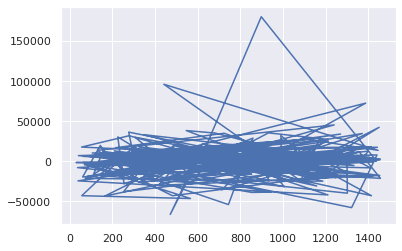

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


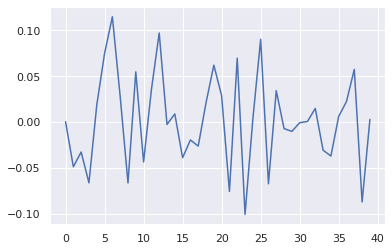

In [685]:
#Should be random and not a pattern.
plt.plot(errors)
plt.show()

#autocorrelation features. Should have low correlation. Not sure cutoff? -.1 to .1 is good
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

#### Assumption six: features shouldn't be correlated with the errors. Pvalue should be above .05

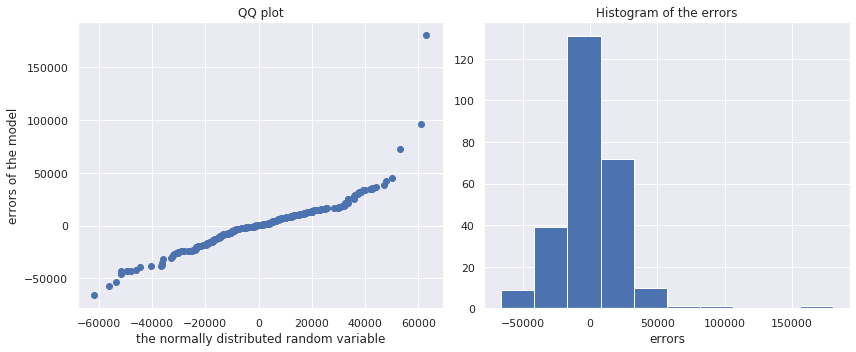

Jarque-Bera test statistics is 2725.2624061905944 and p value is 0.0
Normality test statistics is 157.47670551462082 and p value is 6.373351679165728e-35


In [686]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

#we want a straight-ish line
plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

#we want it to look normalish
plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

#we want low test statistic, high pvalue
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

# Model 4 KNN

### Split Training and Test Set

In [752]:
#Separate target variable from rest of data
X = df4.drop(columns = ['saleprice'])
y = df4['saleprice']
X = sm.add_constant(X)


#split train_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .2)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Build and Fit Model

In [756]:
# Build and fit model
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [757]:
print('Train score: {}'.format(knn.score(X_train, y_train)))
print('Test score: {}'.format(knn.score(X_test, y_test)))


Train score: 0.7682379251933195
Test score: 0.6488177081505314


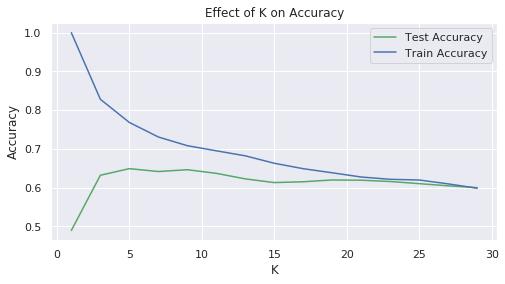

In [755]:
# find optimal K
k_vals = np.arange(1, 30, 2) 
test_accuracy = [] 
train_accuracy = []

for k in k_vals: 
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    test_accuracy.append(knn.score(X_test, y_test)) 
    train_accuracy.append(knn.score(X_train, y_train))

fig = plt.figure(figsize=(8, 4)) 
ax1 = fig.add_subplot(1, 1, 1) 
ax1.plot(k_vals, test_accuracy, '-g', label='Test Accuracy') 
ax1.plot(k_vals, train_accuracy, '-b', label='Train Accuracy') 
ax1.set(xlabel='K', ylabel='Accuracy') 
ax1.set_title('Effect of K on Accuracy') 
ax1.legend() 
plt.show()


# Model 5 KNN MinMaxScaled

In [0]:
#scale and split data

X2 = df4.drop(columns = ['saleprice'])
X2 = MinMaxScaler().fit_transform(X2)
y = df4['saleprice']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, random_state = 42, test_size = .2)

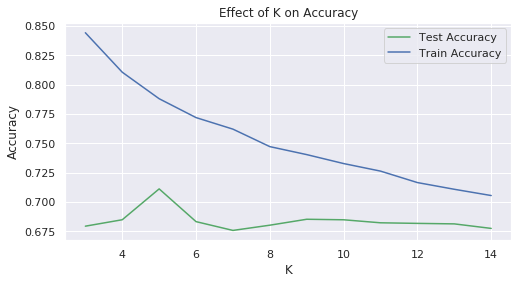

In [759]:
# find optimal K
k_vals = np.arange(3, 15, 1) 
test_accuracy = [] 
train_accuracy = []

for k in k_vals: 
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    knn.fit(X2_train, y2_train)
    test_accuracy.append(knn.score(X2_test, y2_test)) 
    train_accuracy.append(knn.score(X2_train, y2_train))

fig = plt.figure(figsize=(8, 4)) 
ax1 = fig.add_subplot(1, 1, 1) 
ax1.plot(k_vals, test_accuracy, '-g', label='Test Accuracy') 
ax1.plot(k_vals, train_accuracy, '-b', label='Train Accuracy') 
ax1.set(xlabel='K', ylabel='Accuracy') 
ax1.set_title('Effect of K on Accuracy') 
ax1.legend() 
plt.show()


In [760]:
# Build and fit model
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
knn.fit(X2_train, y2_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [761]:
print('Train score: {}'.format(knn.score(X2_train, y2_train)))
print('Test score: {}'.format(knn.score(X2_test, y2_test)))


Train score: 0.7880675274981573
Test score: 0.7112105081768222


# Model 6 KNN StandardScaled

In [0]:
#scale and split data
X5 = df4.drop(columns = ['saleprice'])
X5 = StandardScaler().fit_transform(X5)
y = df4['saleprice']

X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y, random_state = 42, test_size = .2)

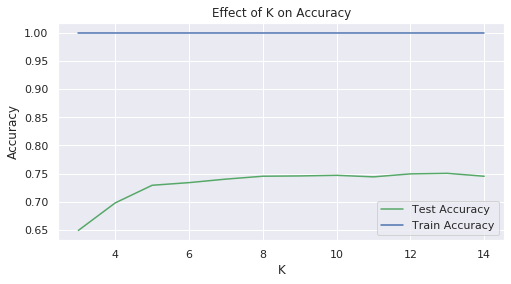

In [771]:
# find optimal K
k_vals = np.arange(3, 15, 1) 
test_accuracy = [] 
train_accuracy = []

for k in k_vals: 
    knn = neighbors.KNeighborsRegressor(n_neighbors=k, weights = 'distance')
    knn.fit(X5_train, y5_train)
    test_accuracy.append(knn.score(X5_test, y5_test)) 
    train_accuracy.append(knn.score(X5_train, y5_train))

fig = plt.figure(figsize=(8, 4)) 
ax1 = fig.add_subplot(1, 1, 1) 
ax1.plot(k_vals, test_accuracy, '-g', label='Test Accuracy') 
ax1.plot(k_vals, train_accuracy, '-b', label='Train Accuracy') 
ax1.set(xlabel='K', ylabel='Accuracy') 
ax1.set_title('Effect of K on Accuracy') 
ax1.legend() 
plt.show()

In [772]:
# Build and fit model
knn = neighbors.KNeighborsRegressor(n_neighbors=10, weights = 'distance', p = 1)
knn.fit(X5_train, y5_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=1,
                    weights='distance')

In [773]:
print('Train score: {}'.format(knn.score(X5_train, y5_train)))
print('Test score: {}'.format(knn.score(X5_test, y5_test)))

Train score: 1.0
Test score: 0.7914735865314443


# Conclusion

With much feature analysis, feature transformation, and careful feature selection, it was possible to get an R squared of 90% with the OLS model. 

With the KNN model, I was only able to get a test score of 79%. 

KNN is great because it does not require parametric features and is therefore very flexible. However, the relationships from the model aren't as easy to understand as OLS.  

By far, I spent the most time on the OLS model. OLS is better at predicting a linear relationship when you have the right feature selection and parametric data. However, getting to this point can take a considerable amount of time.

Both models produced decent results. 

If I had to produce the results in an afternoon, I would go with the KNN model immediately. Then, if I had more time to dive into every feature, I would compare with the OLS model. 

If the data originally met the linear regression assumptions, the OLS model would be more powerful. But if it doesn't come that way to start with, KNN is a good way to get a baseline model. 